# Training Bert and Roberta for classifications

**Import Libraries**

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import kagglehub


**Import IMDB dataset and preprocess**

In [2]:
def load_imdb_data(data_file):
  df = pd.read_csv(data_file)
  texts = df['review'].tolist()
  labels = [1 if sentiment == 'positive' else 0 for sentiment in df['sentiment'].tolist()]
  return texts, labels

In [3]:
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
path = "/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"

print("Path to dataset file:", path)
texts, labels = load_imdb_data(path)

Path to dataset file: /kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


**Custom dataset class for text classification**

In [4]:
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

**Custom BERT classifier**

In [5]:
class BERTClassifier(nn.Module):
  def __init__(self, bert_model_name, num_classes):
    super(BERTClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits

**Define train function**

In [6]:
def train(model, data_loader, optimizer, scheduler, device):
  model.train()
  for batch in data_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

**Build evaluation method**

In [7]:
def evaluate(model , data_loader, device):
  model.eval()
  predictions = []
  actual_lables = []
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      predictions.extend(preds.cpu().tolist())
      actual_lables.extend(labels.cpu().tolist())

  return accuracy_score(actual_lables, predictions), classification_report(actual_lables, predictions,output_dict = True)

**Build prediction method**

In [8]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return "positive" if preds.item() == 1 else "negative"

**Define model's parameters**

In [9]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

**Load and split the data**

In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

**Init tokenizer, dataset, data loader**

In [11]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Set up the device and model**

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier(bert_model_name, num_classes).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Set up optimizer and learning rate scheduler**

In [13]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

**Train the model**

In [14]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/4
Validation Accuracy: 0.8850
{'0': {'precision': 0.9294568402073473, 'recall': 0.831284015319492, 'f1-score': 0.8776335390508618, 'support': 4961.0}, '1': {'precision': 0.8495416142369225, 'recall': 0.9378845008930343, 'f1-score': 0.8915299000188643, 'support': 5039.0}, 'accuracy': 0.885, 'macro avg': {'precision': 0.8894992272221349, 'recall': 0.8845842581062632, 'f1-score': 0.8845817195348631, 'support': 10000.0}, 'weighted avg': {'precision': 0.8891875578408502, 'recall': 0.885, 'f1-score': 0.8846359153426383, 'support': 10000.0}}
Epoch 2/4
Validation Accuracy: 0.8962
{'0': {'precision': 0.9237416288615252, 'recall': 0.8619229993952832, 'f1-score': 0.891762252346194, 'support': 4961.0}, '1': {'precision': 0.8724632284490784, 'recall': 0.9299464179400675, 'f1-score': 0.9002881844380404, 'support': 5039.0}, 'accuracy': 0.8962, 'macro avg': {'precision': 0.8981024286553019, 'recall': 0.8959347086676753, 'f1-score': 0.8960252183921171, 'support': 10000.0}, 'weighted avg': {'pre

**Saving the final bert model**

In [15]:
torch.save(model.state_dict(), 'bert_classifier.pth')

**Custom RoBERTa classifier**

In [24]:
from transformers import DebertaTokenizer, DebertaModel

class DeBERTaClassifier(nn.Module):
  def __init__(self, roberta_model_name, num_classes):
    super(DeBERTaClassifier, self).__init__()
    self.deberta = DebertaModel.from_pretrained(deberta_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.deberta.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.last_hidden_state[:, 0]
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits


**RoBERTa model training**

In [25]:
print("\n" + "="*30)
print("Training deberta")
print("="*30)

deberta_model_name = 'microsoft/deberta-base'
deberta_tokenizer = DebertaTokenizer.from_pretrained(deberta_model_name)

train_dataset_deberta = TextClassificationDataset(train_texts, train_labels, deberta_tokenizer, max_length)
val_dataset_deberta = TextClassificationDataset(val_texts, val_labels, deberta_tokenizer, max_length)
train_dataloader_deberta = DataLoader(train_dataset_deberta, batch_size=batch_size, shuffle=True)
val_dataloader_deberta = DataLoader(val_dataset_deberta, batch_size=batch_size)

roberta_model = DeBERTaClassifier(deberta_model_name, num_classes).to(device)

deberta_optimizer = AdamW(roberta_model.parameters(), lr=learning_rate)
total_steps_deberta = len(train_dataloader_deberta) * num_epochs
deberta_scheduler = get_linear_schedule_with_warmup(deberta_optimizer, num_warmup_steps=0, num_training_steps=total_steps_deberta)



Training deberta


In [26]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(roberta_model, train_dataloader_deberta, deberta_optimizer, deberta_scheduler, device)
    accuracy, report = evaluate(roberta_model, val_dataloader_deberta, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.9126
{'0': {'precision': 0.9498128989654413, 'recall': 0.8697843176778876, 'f1-score': 0.9080387205387206, 'support': 4961.0}, '1': {'precision': 0.881619937694704, 'recall': 0.9547529271680889, 'f1-score': 0.9167301829268293, 'support': 5039.0}, 'accuracy': 0.9126, 'macro avg': {'precision': 0.9157164183300727, 'recall': 0.9122686224229882, 'f1-score': 0.9123844517327749, 'support': 10000.0}, 'weighted avg': {'precision': 0.9154504657811169, 'recall': 0.9126, 'f1-score': 0.9124183484360885, 'support': 10000.0}}
Epoch 2/4
Validation Accuracy: 0.9215
{'0': {'precision': 0.9301606922126081, 'recall': 0.9100987704091917, 'f1-score': 0.9200203769740194, 'support': 4961.0}, '1': {'precision': 0.9133307423241352, 'recall': 0.9327247469736059, 'f1-score': 0.9229258713794797, 'support': 5039.0}, 'accuracy': 0.9215, 'macro avg': {'precision': 0.9217457172683716, 'recall': 0.9214117586913988, 'f1-score': 0.9214731241767495, 'support': 10000.0}, 'weighted avg': {'

**Saving the final RoBERTa model**

In [27]:
torch.save(roberta_model.state_dict(), 'DeBERTa_classifier.pth')

**In order to load model later:**

*Im saving only the model weight


```
roberta_model = RoBERTaClassifier('roberta-base', num_classes)
roberta_model.load_state_dict(torch.load('RoBERTa_classifier.pth'))
roberta_model.to(device)
roberta_model.eval()
```



**Save Weight to computer**

In [28]:
from google.colab import files
files.download('DeBERTa_classifier.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Merging using TA

**Load Weight**

GPU....

In [29]:
from google.colab import drive

drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

deberta_model = DeBERTaClassifier('microsoft/deberta-base', num_classes)

deberta_path = '/content/drive/MyDrive/Colab Notebooks/DeBERTa_classifier.pth'
bert_path = '/content/drive/MyDrive/Colab Notebooks/bert_classifier.pth'


Mounted at /content/drive


In [30]:
deberta_model1 = DeBERTaClassifier('microsoft/deberta-base', num_classes)
deberta_model1.load_state_dict(torch.load(deberta_path, map_location=torch.device('cpu')))
deberta_model1.to(device)
deberta_model1.eval()

DeBERTaClassifier(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fal

In [31]:
bert_model1 = BERTClassifier('bert-base-uncased', num_classes)
bert_model1.load_state_dict(torch.load(bert_path, map_location=torch.device('cpu')))
bert_model1.to(device)
bert_model1.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

**Merge Using TA**


In [33]:
import torch.nn as nn

def merge_models(bert_model1, deberta_model1, alpha=0.7, beta=0.3):
    assert abs(alpha + beta - 1.0) < 1e-5, "Alpha and Beta must sum to 1."

    merged_model = BERTClassifier('bert-base-uncased', num_classes=2)

    matched_params = 0
    total_params = 0

    for merged_param, param1, param2 in zip(
        merged_model.bert.parameters(),
        bert_model1.bert.parameters(),
        deberta_model1.deberta.parameters()
    ):
        total_params += 1
        if merged_param.shape != param1.shape or merged_param.shape != param2.shape:
            print(f"Skipping param due to shape mismatch: {merged_param.shape}")
            continue
        with torch.no_grad():
            merged_param.copy_(alpha * param1 + beta * param2)
            matched_params += 1

    merged_model.dropout.load_state_dict(bert_model1.dropout.state_dict())

    if bert_model1.fc.weight.shape == deberta_model1.fc.weight.shape:
        with torch.no_grad():
            merged_model.fc.weight.copy_(
                alpha * bert_model1.fc.weight + beta * deberta_model1.fc.weight
            )
            merged_model.fc.bias.copy_(
                alpha * bert_model1.fc.bias + beta * deberta_model1.fc.bias
            )
        print("✅ Successfully merged the fc/classifier layers.")
    else:
        merged_model.fc.load_state_dict(bert_model1.fc.state_dict())
        print("❌ Cannot merge fc layers: shape mismatch.")

    print(f"\n✅ Merged {matched_params}/{total_params} encoder parameters successfully.")

    return merged_model


# Evaluating
use different weight distrabution starting with bert at 40% all the way to bert at 80%

In [35]:
results = []

for alpha in [round(x * 0.05, 2) for x in range(8, 17)]:
    beta = round(1.0 - alpha, 2)
    print(f"\n🔄 Merging with alpha={alpha:.2f}, beta={beta:.2f}")

    merged_model = merge_models(bert_model1, deberta_model1, alpha, beta)
    merged_model.to(device)

    accuracy, report = evaluate(merged_model, val_dataloader, device)

    results.append({
        'alpha': alpha,
        'accuracy': accuracy,
        'report': report
    })

    print(f"✅ Alpha={alpha:.2f} | Accuracy={accuracy:.4f}")


🔄 Merging with alpha=0.40, beta=0.60
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due

In [36]:
accuracy, report = evaluate(bert_model1, val_dataloader, device)
print(f"✅ Alpha= 1 (bert model) | Accuracy={accuracy:.4f}")
results.append({
    'alpha': 1,
    'accuracy': accuracy,
    'report': report
})
accuracy, report = evaluate(deberta_model1, val_dataloader_deberta, device)
print(f"✅ Alpha= 0 (DeBERTa model) | Accuracy={accuracy:.4f}")
results.append({
    'alpha': 0,
    'accuracy': accuracy,
    'report': report
})

✅ Alpha= 1 (bert model) | Accuracy=0.8970
✅ Alpha= 0 (DeBERTa model) | Accuracy=0.9232


In [37]:
print(results)

[{'alpha': 0.4, 'accuracy': 0.504, 'report': {'0': {'precision': 1.0, 'recall': 0.00020157226365652087, 'f1-score': 0.00040306328093510683, 'support': 4961.0}, '1': {'precision': 0.5039503950395039, 'recall': 1.0, 'f1-score': 0.6701689054395531, 'support': 5039.0}, 'accuracy': 0.504, 'macro avg': {'precision': 0.751975197519752, 'recall': 0.5001007861318283, 'f1-score': 0.3352859843602441, 'support': 10000.0}, 'weighted avg': {'precision': 0.7500406040604061, 'recall': 0.504, 'f1-score': 0.3378980711446627, 'support': 10000.0}}}, {'alpha': 0.45, 'accuracy': 0.504, 'report': {'0': {'precision': 0.6, 'recall': 0.0006047167909695626, 'f1-score': 0.0012082158679017317, 'support': 4961.0}, '1': {'precision': 0.503951975987994, 'recall': 0.9996030958523516, 'f1-score': 0.6700811493947053, 'support': 5039.0}, 'accuracy': 0.504, 'macro avg': {'precision': 0.5519759879939969, 'recall': 0.5001039063216606, 'f1-score': 0.33564468263130354, 'support': 10000.0}, 'weighted avg': {'precision': 0.5516

**Graph & Plots**

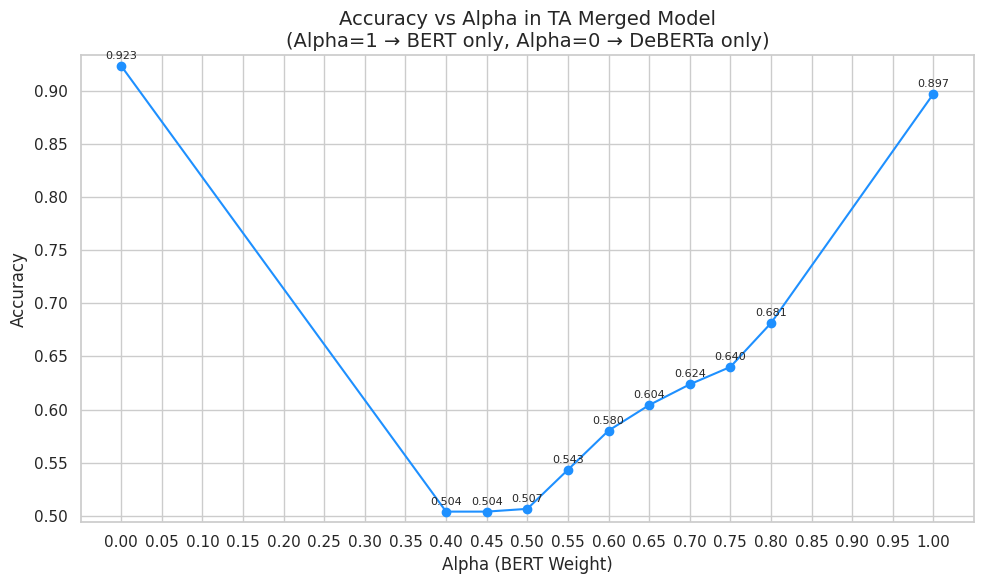

In [48]:
import matplotlib.pyplot as plt
import numpy as np

results = sorted(results, key=lambda x: x['alpha'])

alphas = [entry['alpha'] for entry in results]
accuracies = [entry['accuracy'] for entry in results]

plt.figure(figsize=(10, 6))
plt.plot(alphas, accuracies, marker='o', linestyle='-', color='dodgerblue')
plt.title("Accuracy vs Alpha in TA Merged Model\n(Alpha=1 → BERT only, Alpha=0 → DeBERTa only)", fontsize=14)
plt.xlabel("Alpha (BERT Weight)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(np.arange(0.0, 1.05, 0.05))
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)

for alpha, acc in zip(alphas, accuracies):
    plt.annotate(f"{acc:.3f}", (alpha, acc), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

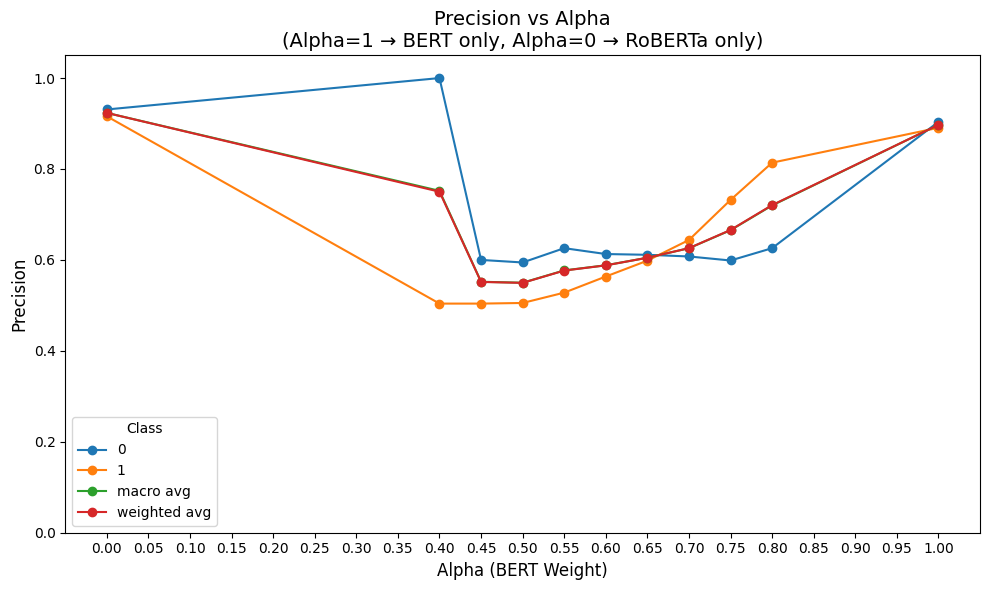

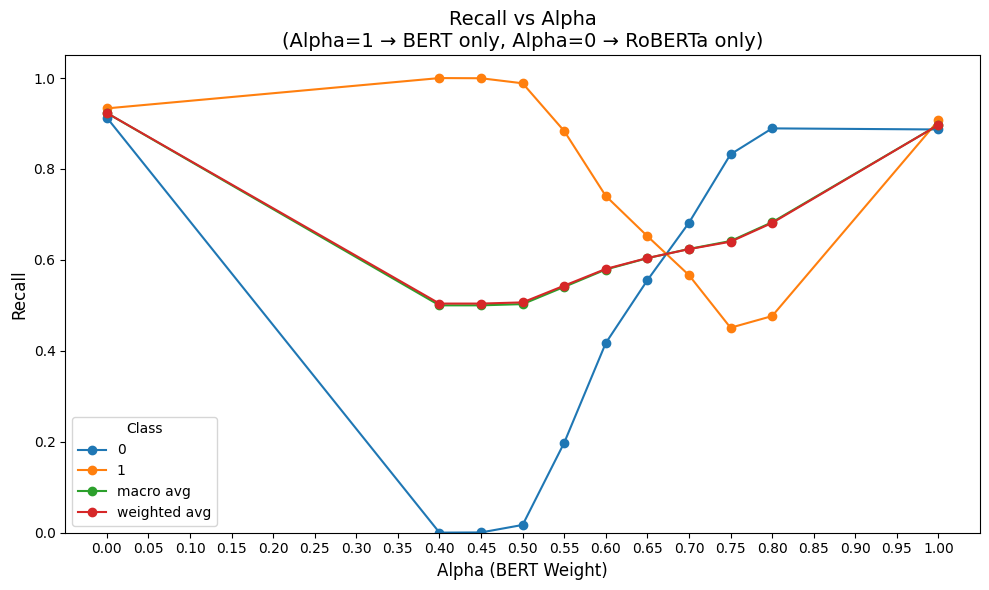

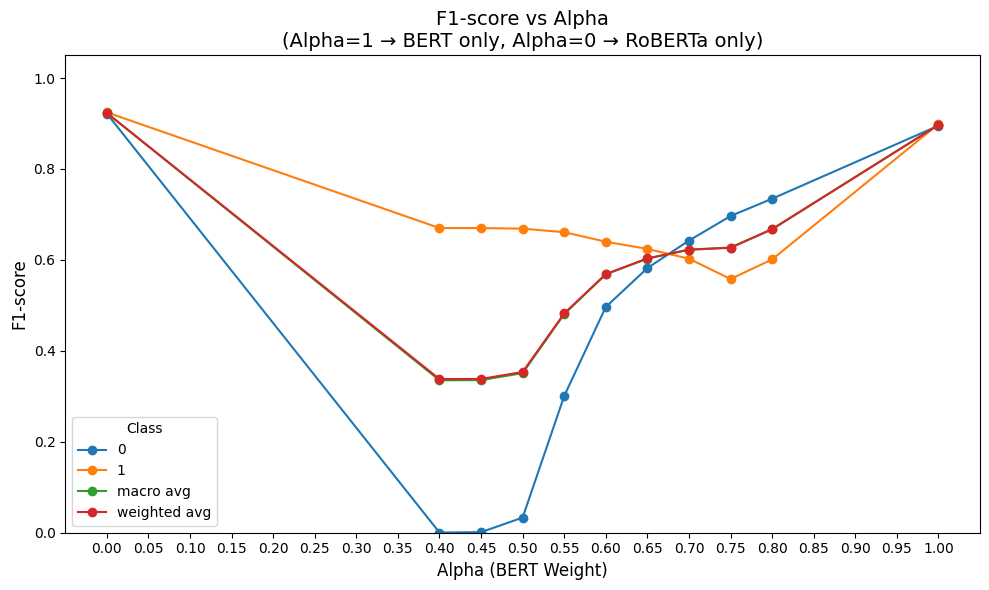

In [40]:
classes = ['0', '1', 'macro avg', 'weighted avg']
metrics = ['precision', 'recall', 'f1-score']

metric_data = {cls: {metric: [] for metric in metrics} for cls in classes}
alphas = []

for entry in sorted(results, key=lambda x: x['alpha']):
    report = entry['report']
    alpha = entry['alpha']
    alphas.append(alpha)
    for cls in classes:
        for metric in metrics:
            metric_data[cls][metric].append(report[cls][metric])

for metric in metrics:
    plt.figure(figsize=(10, 6))
    for cls in classes:
        plt.plot(alphas, metric_data[cls][metric], marker='o', label=f"{cls}")
    plt.title(f"{metric.capitalize()} vs Alpha\n(Alpha=1 → BERT only, Alpha=0 → DeBERTa only)", fontsize=14)
    plt.xlabel("Alpha (BERT Weight)", fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(title="Class")
    plt.ylim(0, 1.05)
    plt.xticks(np.arange(0.0, 1.05, 0.05))
    plt.tight_layout()
    plt.show()


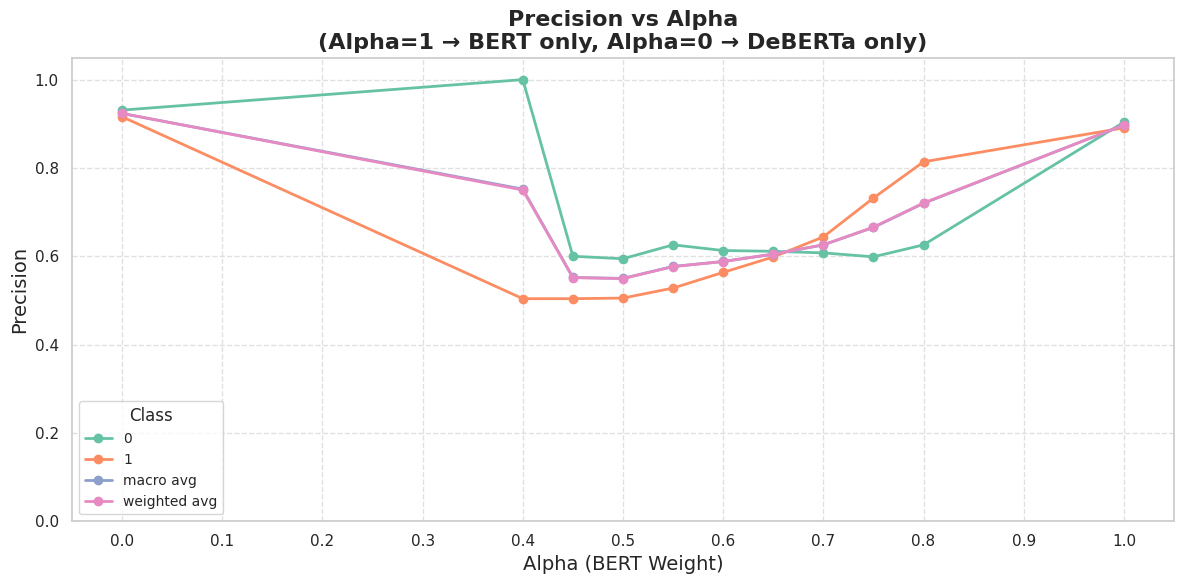

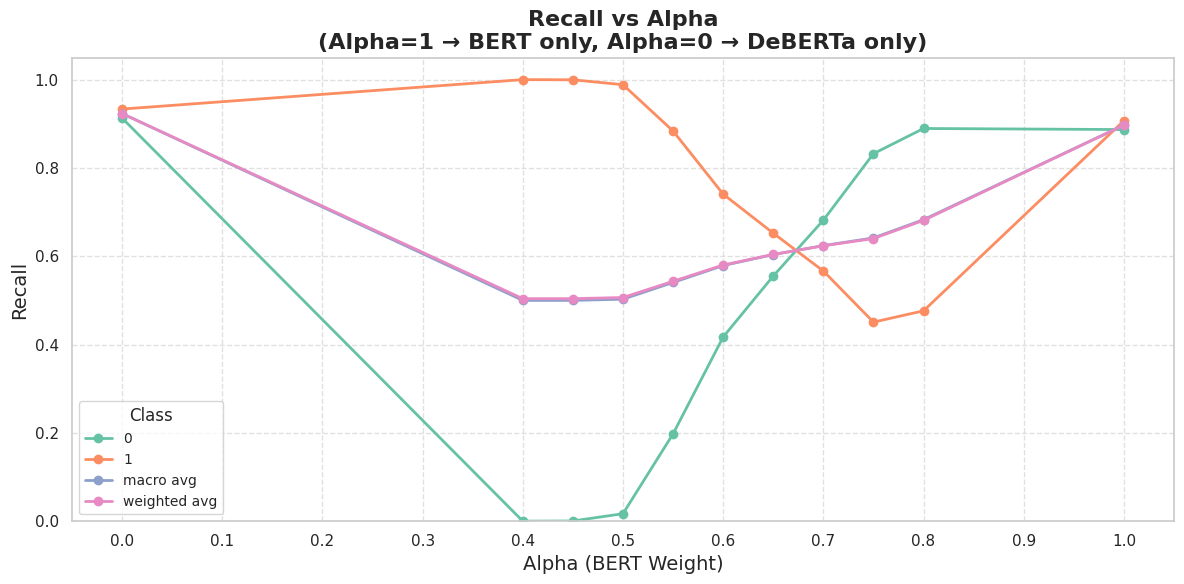

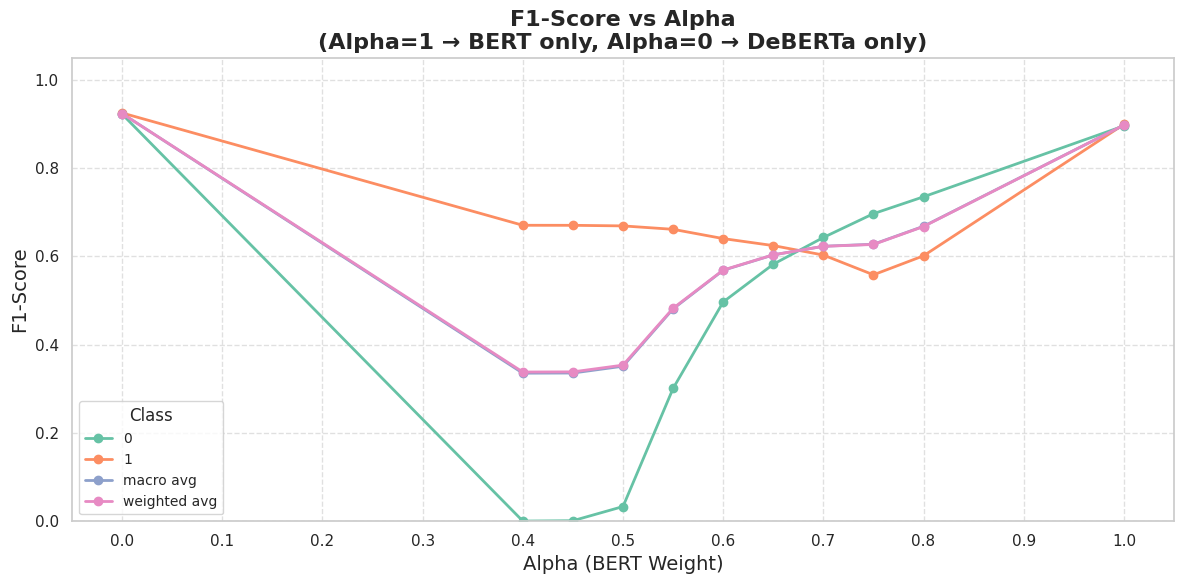

In [41]:
import seaborn as sns

# Optional: use a better aesthetic style
sns.set(style="whitegrid", context="notebook", palette="Set2")

# Data structure setup (same as yours)
classes = ['0', '1', 'macro avg', 'weighted avg']
metrics = ['precision', 'recall', 'f1-score']
metric_data = {cls: {metric: [] for metric in metrics} for cls in classes}
alphas = []

# Fill data
for entry in sorted(results, key=lambda x: x['alpha']):
    report = entry['report']
    alpha = entry['alpha']
    alphas.append(alpha)
    for cls in classes:
        for metric in metrics:
            metric_data[cls][metric].append(report[cls][metric])

# Plotting
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for cls in classes:
        plt.plot(alphas, metric_data[cls][metric], marker='o', label=cls, linewidth=2)

    plt.title(f"{metric.title()} vs Alpha\n(Alpha=1 → BERT only, Alpha=0 → DeBERTa only)", fontsize=16, fontweight='bold')
    plt.xlabel("Alpha (BERT Weight)", fontsize=14)
    plt.ylabel(metric.title(), fontsize=14)
    plt.ylim(0, 1.05)
    plt.xticks(np.round(np.linspace(0, 1, 11), 2))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Class", fontsize=10)
    plt.tight_layout()
    plt.show()


# Merging with SLERP

In [49]:
def slerp_merge(w1, w2, alpha):
    dot = torch.sum(w1 * w2)
    norm1 = torch.norm(w1)
    norm2 = torch.norm(w2)
    theta = torch.acos(dot / (norm1 * norm2 + 1e-10))

    if theta.item() == 0.0:
        return (1 - alpha) * w1 + alpha * w2

    merged_weight = (torch.sin((1 - alpha) * theta) / torch.sin(theta) * w1 / norm1 +
                    torch.sin(alpha * theta) / torch.sin(theta) * w2 / norm2) * (
                        norm1 * norm2 * torch.sin(theta)) / (torch.sin((1 - alpha) * theta) * norm2 +
                                                            torch.sin(alpha * theta) * norm1 + 1e-10)
    return merged_weight


In [50]:
def merge_models_slerp(bert_model1, deberta_model1, alpha=0.7):

    merged_model = BERTClassifier('bert-base-uncased', num_classes=2)

    matched_params = 0
    total_params = 0

    for merged_param, param1, param2 in zip(
        merged_model.bert.parameters(),
        bert_model1.bert.parameters(),
        deberta_model1.deberta.parameters()
    ):
        total_params += 1
        if merged_param.shape != param1.shape or merged_param.shape != param2.shape:
            print(f"Skipping param due to shape mismatch: {merged_param.shape}")
            continue
        with torch.no_grad():
            merged_param.copy_(slerp_merge(param1, param2, alpha))
            matched_params += 1

    merged_model.dropout.load_state_dict(bert_model1.dropout.state_dict())

    if bert_model1.fc.weight.shape == deberta_model1.fc.weight.shape:
        with torch.no_grad():
            merged_model.fc.weight.copy_(slerp_merge(bert_model1.fc.weight, deberta_model1.fc.weight, alpha))
            merged_model.fc.bias.copy_(slerp_merge(bert_model1.fc.bias, deberta_model1.fc.bias, alpha))
        print("✅ Successfully merged the fc/classifier layers.")
    else:
        merged_model.fc.load_state_dict(bert_model1.fc.state_dict())
        print("❌ Cannot merge fc layers: shape mismatch.")

    print(f"\n✅ Merged {matched_params}/{total_params} encoder parameters successfully.")

    return merged_model


In [51]:
results_slerp = []

for alpha in [round(x * 0.05, 2) for x in range(8, 17)]:
    beta = round(1.0 - alpha, 2)
    print(f"\n🔄 Merging with alpha={alpha:.2f}, beta={beta:.2f}")

    merged_model = merge_models_slerp(bert_model1, deberta_model1, alpha)
    merged_model.to(device)

    accuracy, report = evaluate(merged_model, val_dataloader, device)

    results_slerp.append({
        'alpha': alpha,
        'accuracy': accuracy,
        'report': report
    })

    print(f"✅ Alpha={alpha:.2f} | Accuracy={accuracy:.4f}")


🔄 Merging with alpha=0.40, beta=0.60
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.40 | Accuracy=0.5039

🔄 Merging with alpha=0.45, beta=0.55
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.45 | Accuracy=0.5039

🔄 Merging with alpha=0.50, beta=0.50
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.50 | Accuracy=0.5039

🔄 Merging with alpha=0.55, beta=0.45
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.55 | Accuracy=0.5039

🔄 Merging with alpha=0.60, beta=0.40
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.60 | Accuracy=0.5039

🔄 Merging with alpha=0.65, beta=0.35
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.65 | Accuracy=0.5039

🔄 Merging with alpha=0.70, beta=0.30
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.70 | Accuracy=0.5039

🔄 Merging with alpha=0.75, beta=0.25
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.75 | Accuracy=0.5039

🔄 Merging with alpha=0.80, beta=0.20
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
accuracy, report = evaluate(bert_model1, val_dataloader, device)
print(f"✅ Alpha= 1 (bert model) | Accuracy={accuracy:.4f}")
results_slerp.append({
    'alpha': 1,
    'accuracy': accuracy,
    'report': report
})
accuracy, report = evaluate(deberta_model1, val_dataloader_deberta, device)
print(f"✅ Alpha= 0 (DeBERTa model) | Accuracy={accuracy:.4f}")
results_slerp.append({
    'alpha': 0,
    'accuracy': accuracy,
    'report': report
})

✅ Alpha= 1 (bert model) | Accuracy=0.8970
✅ Alpha= 0 (DeBERTa model) | Accuracy=0.9232


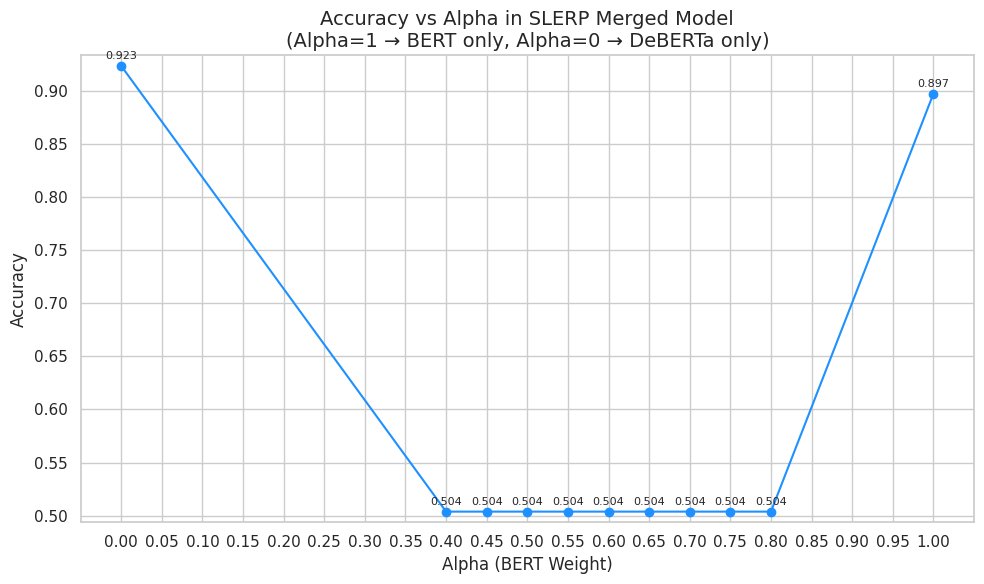

In [53]:
results_slerp = sorted(results_slerp, key=lambda x: x['alpha'])

alphas = [entry['alpha'] for entry in results_slerp]
accuracies = [entry['accuracy'] for entry in results_slerp]

plt.figure(figsize=(10, 6))
plt.plot(alphas, accuracies, marker='o', linestyle='-', color='dodgerblue')
plt.title("Accuracy vs Alpha in SLERP Merged Model\n(Alpha=1 → BERT only, Alpha=0 → DeBERTa only)", fontsize=14)
plt.xlabel("Alpha (BERT Weight)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(np.arange(0.0, 1.05, 0.05))
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)

for alpha, acc in zip(alphas, accuracies):
    plt.annotate(f"{acc:.3f}", (alpha, acc), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

In [58]:
def dare_merge(w1, w2, alpha,density = 0.9):
  mask = (torch.rand_like(w1) < density).float()
  delta = w2 - w1
  merged_weight = w1 + mask * alpha * delta
  return merged_weight

def merge_models_dare(bert_model1, deberta_model1, alpha=0.7):

  merged_model = BERTClassifier('bert-base-uncased', num_classes=2)

  matched_params = 0
  total_params = 0

  for merged_param, param1, param2 in zip(
      merged_model.bert.parameters(),
      bert_model1.bert.parameters(),
      deberta_model1.deberta.parameters()
  ):
      total_params += 1
      if merged_param.shape != param1.shape or merged_param.shape != param2.shape:
          print(f"Skipping param due to shape mismatch: {merged_param.shape}")
          continue
      with torch.no_grad():
          merged_param.copy_(dare_merge(param1, param2, alpha))
          matched_params += 1

  merged_model.dropout.load_state_dict(bert_model1.dropout.state_dict())

  if bert_model1.fc.weight.shape == deberta_model1.fc.weight.shape:
      with torch.no_grad():
          merged_model.fc.weight.copy_(dare_merge(bert_model1.fc.weight, deberta_model1.fc.weight, alpha))
          merged_model.fc.bias.copy_(dare_merge(bert_model1.fc.bias, deberta_model1.fc.bias, alpha))
      print("✅ Successfully merged the fc/classifier layers.")
  else:
      merged_model.fc.load_state_dict(bert_model1.fc.state_dict())
      print("❌ Cannot merge fc layers: shape mismatch.")

  print(f"\n✅ Merged {matched_params}/{total_params} encoder parameters successfully.")

  return merged_model


In [59]:
results_dare = []

for alpha in [round(x * 0.05, 2) for x in range(8, 17)]:
    beta = round(1.0 - alpha, 2)
    print(f"\n🔄 Merging with alpha={alpha:.2f}, beta={beta:.2f}")

    merged_model = merge_models_dare(bert_model1, deberta_model1, alpha)
    merged_model.to(device)

    accuracy, report = evaluate(merged_model, val_dataloader, device)

    results_dare.append({
        'alpha': alpha,
        'accuracy': accuracy,
        'report': report
    })

    print(f"✅ Alpha={alpha:.2f} | Accuracy={accuracy:.4f}")


🔄 Merging with alpha=0.40, beta=0.60
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.55 | Accuracy=0.5039

🔄 Merging with alpha=0.60, beta=0.40
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.60 | Accuracy=0.5039

🔄 Merging with alpha=0.65, beta=0.35
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([3072, 768])
Skipping param due to shape mismatch: torch.Size([3072])
Skipping param due to shape mismatch: torch.Size([768, 3072])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch.Size([768, 768])
Skipping param due to shape mismatch: torch.Size([768])
Skipping param due to shape mismatch: torch

In [63]:
accuracy, report = evaluate(bert_model1, val_dataloader, device)
print(f"✅ Alpha= 1 (bert model) | Accuracy={accuracy:.4f}")
results_dare.append({
    'alpha': 1,
    'accuracy': accuracy,
    'report': report
})
accuracy, report = evaluate(deberta_model1, val_dataloader_deberta, device)
print(f"✅ Alpha= 0 (DeBERTa model) | Accuracy={accuracy:.4f}")
results_dare.append({
    'alpha': 0,
    'accuracy': accuracy,
    'report': report
})

✅ Alpha= 1 (bert model) | Accuracy=0.8970
✅ Alpha= 0 (DeBERTa model) | Accuracy=0.9232


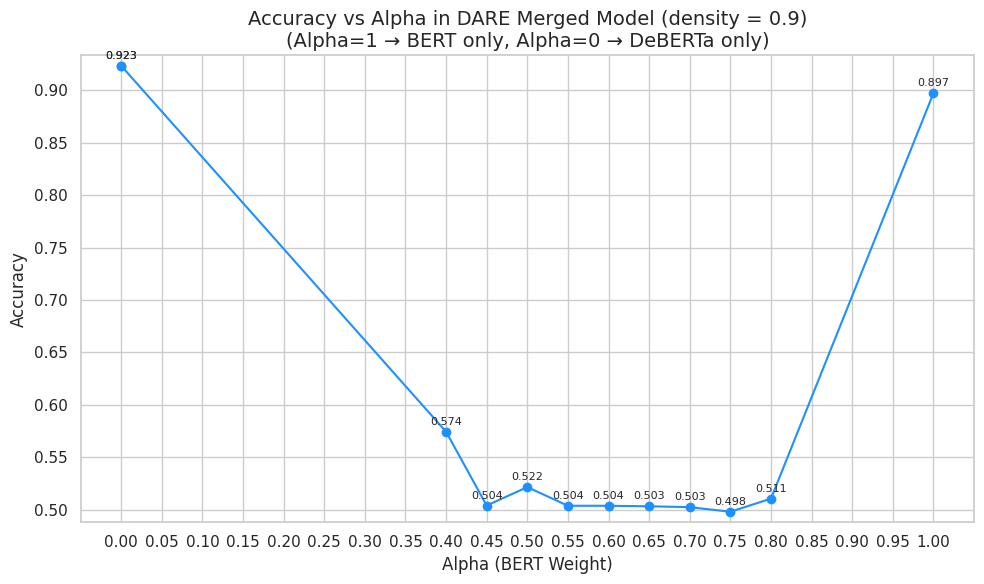

In [64]:
results_dare = sorted(results_dare, key=lambda x: x['alpha'])

alphas = [entry['alpha'] for entry in results_dare]
accuracies = [entry['accuracy'] for entry in results_dare]

plt.figure(figsize=(10, 6))
plt.plot(alphas, accuracies, marker='o', linestyle='-', color='dodgerblue')
plt.title("Accuracy vs Alpha in DARE Merged Model (density = 0.9)\n(Alpha=1 → BERT only, Alpha=0 → DeBERTa only)", fontsize=14)
plt.xlabel("Alpha (BERT Weight)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(np.arange(0.0, 1.05, 0.05))
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)

for alpha, acc in zip(alphas, accuracies):
    plt.annotate(f"{acc:.3f}", (alpha, acc), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.tight_layout()
plt.show()